<a href="https://colab.research.google.com/github/Kryptera-K/NRG-Directional-Reflex-Trend-DRT-Strategy/blob/main/NRG_D1_%5B'ADX_Higher20'%2C_'RSI_Higher_Than_OB'%5D_%5B'Reflex_FastCrossUpSlow'%2C_'DI__Is_Falling'%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.7/527.7 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import vectorbt as vbt

# -------------------------
# Parameters
# -------------------------
symbol = "NRG"
start_date = "2000-01-01"
end_date = "2026-01-01"
interval = "1d"

# -------------------------
# Download Data
# -------------------------
df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)

# -------------------------
# ADX Calculation
# -------------------------
ADX_period = 14

def calculate_adx(data, period=14):
    df = data.copy()
    df['H-L'] = df['High'] - df['Low']
    df['H-PC'] = abs(df['High'] - df['Close'].shift(1))
    df['L-PC'] = abs(df['Low'] - df['Close'].shift(1))
    df['TR'] = df[['H-L', 'H-PC', 'L-PC']].max(axis=1)

    df['+DM'] = np.where((df['High'] - df['High'].shift(1)) > (df['Low'].shift(1) - df['Low']),
                         np.maximum(df['High'] - df['High'].shift(1), 0), 0)
    df['-DM'] = np.where((df['Low'].shift(1) - df['Low']) > (df['High'] - df['High'].shift(1)),
                         np.maximum(df['Low'].shift(1) - df['Low'], 0), 0)

    df['TRn'] = df['TR'].rolling(window=period).sum()
    df['+DMn'] = df['+DM'].rolling(window=period).sum()
    df['-DMn'] = df['-DM'].rolling(window=period).sum()

    df['+DI'] = 100 * (df['+DMn'] / df['TRn'])
    df['-DI'] = 100 * (df['-DMn'] / df['TRn'])

    df['DX'] = 100 * abs(df['+DI'] - df['-DI']) / (df['+DI'] + df['-DI'])
    df['ADX'] = df['DX'].rolling(window=period).mean()

    return df

df = calculate_adx(df, ADX_period)
df['ADX_Higher20'] = df['ADX'] > 20

# -------------------------
# RSI Calculation
# -------------------------
rsi_period = 14
overbought_level = 70

delta = df['Close'].diff()
up = delta.clip(lower=0)
down = -delta.clip(upper=0)

roll_up = up.ewm(span=rsi_period, adjust=False).mean()
roll_down = down.ewm(span=rsi_period, adjust=False).mean()
rs = roll_up / roll_down
df['RSI'] = 100 - (100 / (1 + rs))

df['RSI_Higher_Than_OB'] = df['RSI'] > overbought_level

# -------------------------
# Reflex / Fast-Slow Smoothing
# -------------------------
def rma(series, period):
    return series.ewm(alpha=1/period, adjust=False).mean()

reflex_fast_period = 5
reflex_slow_period = 13
rsi_reflex_period = 14

delta_rma = rma(df['Close'].diff(), rsi_reflex_period)
df['Fast_Reflex'] = rma(delta_rma, reflex_fast_period)
df['Slow_Reflex'] = rma(delta_rma, reflex_slow_period)

df['Reflex_FastCrossUpSlow'] = (df['Fast_Reflex'] > df['Slow_Reflex']) & \
                               (df['Fast_Reflex'].shift(1) <= df['Slow_Reflex'].shift(1))

# -------------------------
# DI- Falling
# -------------------------
df['DI-_Is_Falling'] = df['-DI'] < df['-DI'].shift(5)

# -------------------------
# Entry / Exit Signals
# -------------------------
entry_conditions = ['ADX_Higher20', 'RSI_Higher_Than_OB']
exit_conditions  = ['Reflex_FastCrossUpSlow', 'DI-_Is_Falling']

df['entry_signal'] = df[entry_conditions].all(axis=1)
df['exit_signal']  = df[exit_conditions].all(axis=1)

# -------------------------
# Backtest
# -------------------------
entries = df['entry_signal'].shift(1).astype(bool).fillna(False).to_numpy()
exits = df['exit_signal'].shift(1).astype(bool).fillna(False).to_numpy()

pf = vbt.Portfolio.from_signals(
    close=df['Open'],
    entries=entries,
    exits=exits,
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='1d'
)

print(pf.stats())
pf.plot().show()


/tmp/ipython-input-3332205918.py:17: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed


Start                                2003-12-02 00:00:00
End                                  2025-09-26 00:00:00
Period                                5490 days 00:00:00
Start Value                                     100000.0
End Value                                    8097446.218
Total Return [%]                             7997.446218
Benchmark Return [%]                         2196.043435
Max Gross Exposure [%]                             100.0
Total Fees Paid                            130738.576864
Max Drawdown [%]                               43.522893
Max Drawdown Duration                  491 days 00:00:00
Total Trades                                          58
Total Closed Trades                                   57
Total Open Trades                                      1
Open Trade PnL                            -176535.907612
Win Rate [%]                                   63.157895
Best Trade [%]                                156.436991
Worst Trade [%]                

In [ ]:
# -------------------------
# Parameters
# -------------------------
symbol = "NRG"
start_date = "2000-01-01"
end_date = "2026-01-01"
interval = "1d"

# -------------------------
# Download Data
# -------------------------
df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
df

/tmp/ipython-input-1614702258.py:12: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed


,Close,High,Low,Open,Volume
Date,,,,,
2003-12-02,7.226995,7.226995,7.133138,7.133138,160000
2003-12-03,7.320857,7.320857,7.320857,7.320857,300000
2003-12-04,7.602427,7.602427,7.602427,7.602427,50000
2003-12-05,7.602427,7.602427,7.602427,7.602427,0
2003-12-08,8.184339,8.184339,7.883996,7.883996,954000
...,...,...,...,...,...
2025-09-22,170.970001,172.039993,163.500000,164.949997,2580000
2025-09-23,167.429993,171.570007,165.179993,171.160004,2527300
2025-09-24,165.580002,169.149994,165.500000,167.710007,2133700


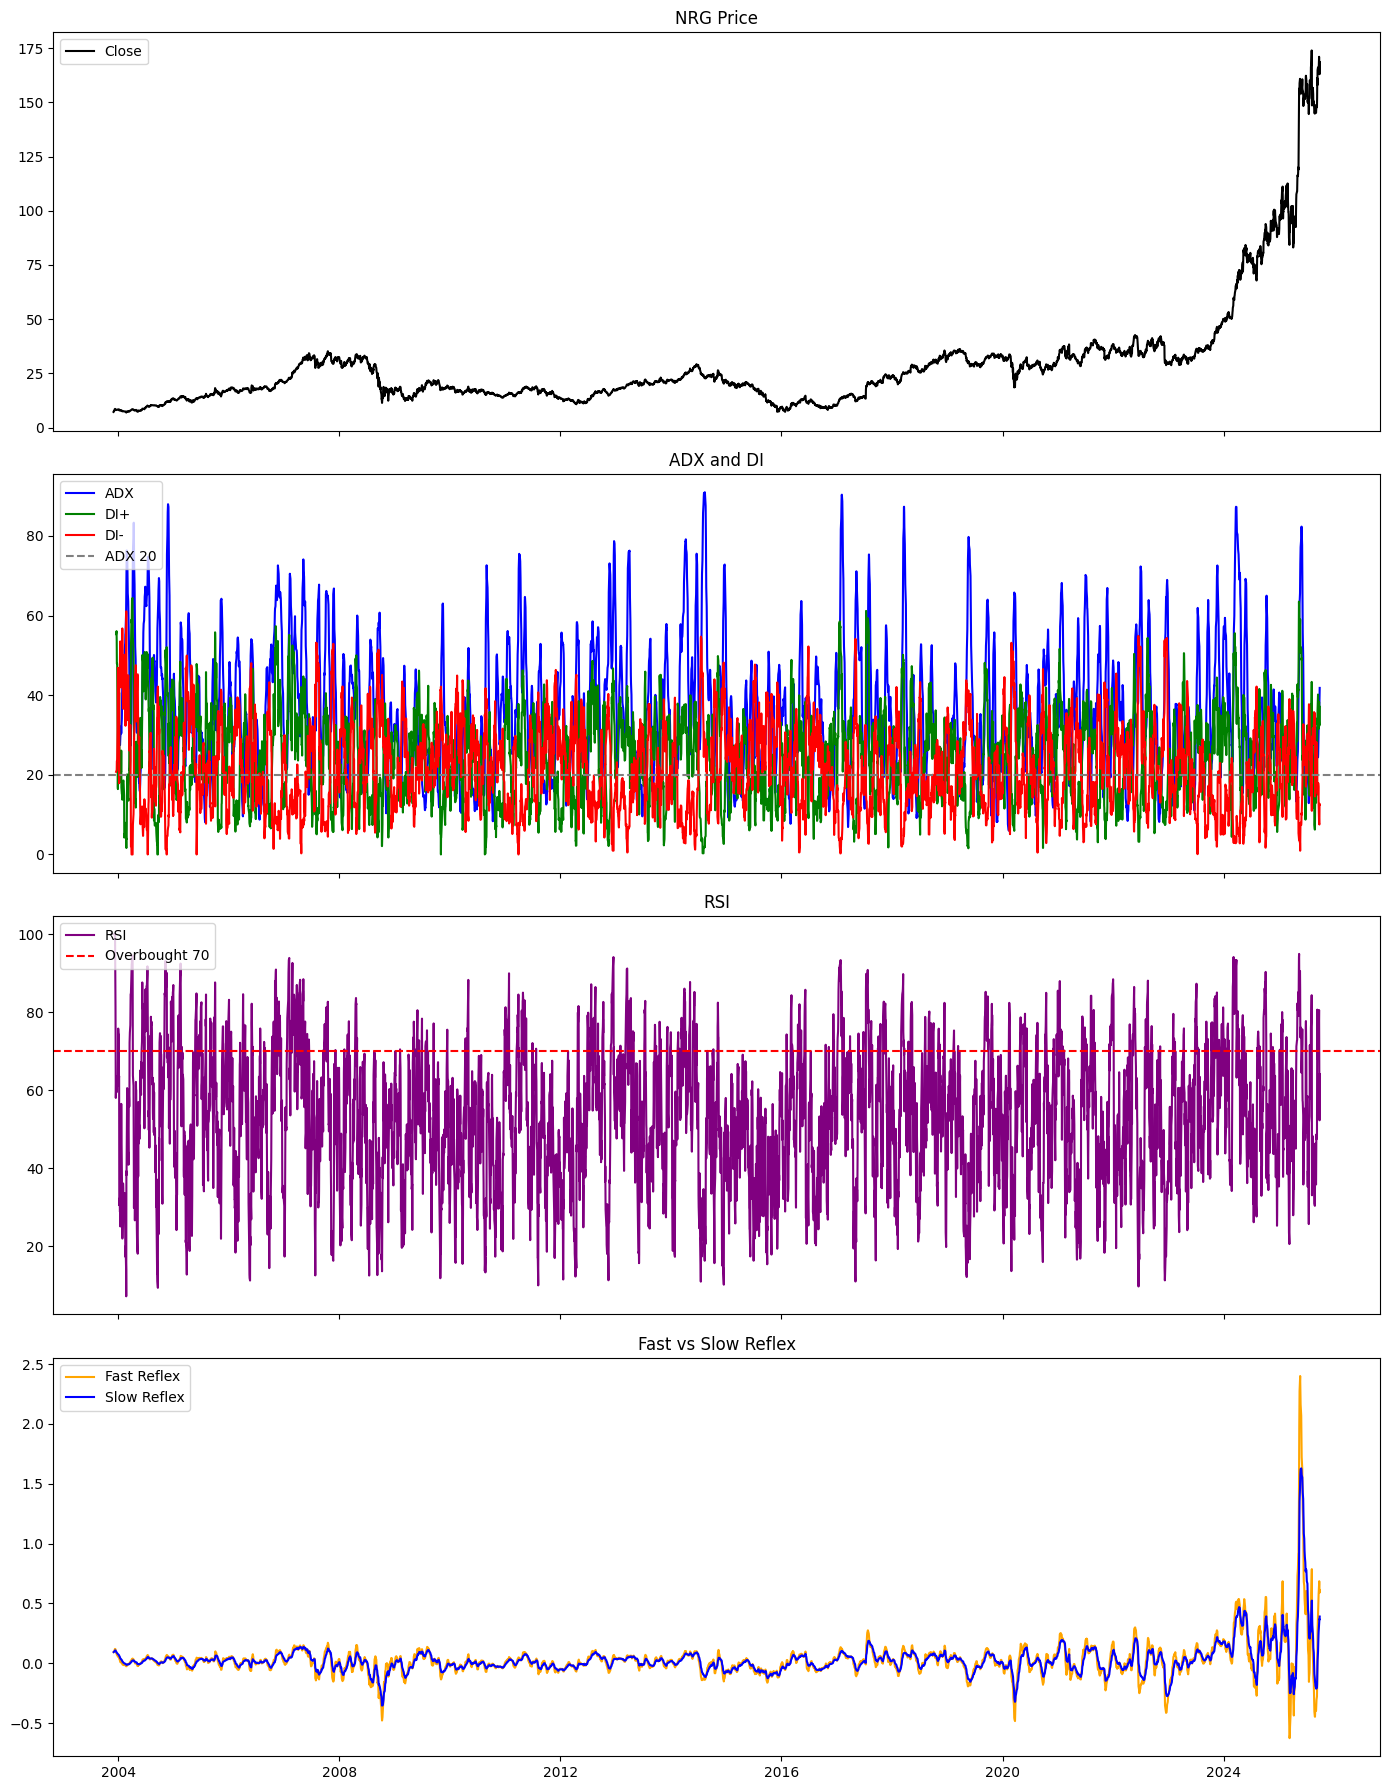

In [ ]:
import matplotlib.pyplot as plt

# -------------------------
# Prepare the figure
# -------------------------
fig, axes = plt.subplots(4, 1, figsize=(14, 18), sharex=True)

# 1. Price
axes[0].plot(df['Close'], label='Close', color='black')
axes[0].set_title(f'{symbol} Price')
axes[0].legend(loc='upper left')

# 2. ADX + DI
axes[1].plot(df['ADX'], label='ADX', color='blue')
axes[1].plot(df['+DI'], label='DI+', color='green')
axes[1].plot(df['-DI'], label='DI-', color='red')
axes[1].axhline(20, color='gray', linestyle='--', label='ADX 20')
axes[1].set_title('ADX and DI')
axes[1].legend(loc='upper left')

# 3. RSI
axes[2].plot(df['RSI'], label='RSI', color='purple')
axes[2].axhline(70, color='red', linestyle='--', label='Overbought 70')
axes[2].set_title('RSI')
axes[2].legend(loc='upper left')

# 4. Fast/Slow Reflex
axes[3].plot(df['Fast_Reflex'], label='Fast Reflex', color='orange')
axes[3].plot(df['Slow_Reflex'], label='Slow Reflex', color='blue')
axes[3].set_title('Fast vs Slow Reflex')
axes[3].legend(loc='upper left')

plt.tight_layout()
plt.show()


In [ ]:
# Buy and Hold Performance Metrics
df_holding = df['Open']
pf_holding = vbt.Portfolio.from_holding(df_holding, init_cash=100_000 , freq='D')
print(pf_holding.stats())

Start                         2003-12-02 00:00:00
End                           2025-09-26 00:00:00
Period                         5490 days 00:00:00
Start Value                              100000.0
End Value                          2296043.434664
Total Return [%]                      2196.043435
Benchmark Return [%]                  2196.043435
Max Gross Exposure [%]                      100.0
Total Fees Paid                               0.0
Max Drawdown [%]                        79.613684
Max Drawdown Duration          2807 days 00:00:00
Total Trades                                    1
Total Closed Trades                             0
Total Open Trades                               1
Open Trade PnL                     2196043.434664
Win Rate [%]                                  NaN
Best Trade [%]                                NaN
Worst Trade [%]                               NaN
Avg Winning Trade [%]                         NaN
Avg Losing Trade [%]                          NaN
